# Introduction

As it can be seen, Jupyter noteeboks interact with Neo4j graph database incredibly well! For this reason, we can use them to interrogate the [gAGDT](https://github.com/francescomambrini/gAGDT) and study arguments of Ancient Greek Grammars.

In this notebook, we take a few paragraphs from H.W. Smyth, *A Greek Grammar for Colleges*, starting from texts and snippets taken from the edition published in the [Perseus Digital Library](http://www.perseus.tufts.edu/hopper/text?doc=Perseus:text:1999.04.0007)

## What we need

Actually, not much! You'll need Jupyter to run this code and the database (in this notebook we access an online copy: contact me to get an access).

Apart from that, all you need is:

* [`py2neo`](http://py2neo.org/) to be able to connect with a graph db from Python
* [`pandas`](http://pandas.pydata.org/) the much-dreaded library for data analysis in Python; not that you need it for much but:
    * it interacts *very* well with neo4j and Jupyter
    * it simplify your life, for you can write easier cypher queries and then manipulate the results with `pandas`
    * it is simply awesome!
* [`matplotlib`](https://matplotlib.org/) (`pyplot`) to generate plots from the pandas' dataframe (you can also have [`seaborn`](http://seaborn.pydata.org/) if you like)
* the [`ipython-cypher`](https://github.com/versae/ipython-cypher) extension, to run cypher queries directly from the Jupyter notebook

## Let's go...

Here is all you need, really!

In [30]:
import py2neo
from py2neo import Graph
import pandas as pd
from matplotlib import pyplot as plt

The following cell is just to load some configuration to store username and pwd to access the db

In [29]:
# loading the DB configurations (username and password)
import json
import os
with open(os.path.expanduser("~/PycharmProjects/config/.pagdt.json")) as f:
    conf = json.load(f)

Here we extablish the connection with the DB (and we store the connection data for later reuse)

In [7]:
g = Graph("http://pagdt.dainst.org:7474/" ,password=conf["pwd"])
conn = "http://{}:{}@pagdt.dainst.org:7474/db/data".format(conf["user"], conf["pwd"])

Now we load the `ipython-cypher` extension that will allow us to run cypher queries directly in our code and we set up 

In [31]:
# load the magic cypher
%load_ext cypher
# set matplotlib to plot inline
%matplotlib inline

The cypher extension is already loaded. To reload it, use:
  %reload_ext cypher


In [122]:
# we might also want to increase the fig. size
plt.rcParams['figure.figsize'] = (10, 6)

In [32]:
# let's test everything
res = %cypher {conn} MATCH (n:Token) \
    where n.lemma = "φθογγή" \
    RETURN n.form as Form, count(*) as Count order by Count desc
    
df = res.get_dataframe()

5 rows affected.


In [33]:
df

,Form,Count
0,φθογγὴν,4
1,φθογγῆς,3
2,φθογγὰς,1
3,φθογγῇ,1
4,φθογγὰ,1


# A Greek Grammar for college

In [41]:
from IPython.display import HTML, IFrame

## Syntax of the simple sentence

### §917: copula

Let's read the text from [Perseus](http://www.perseus.tufts.edu/hopper/text?doc=Perseus%3Atext%3A1999.04.0007%3Asmythp%3D917)

In [45]:
IFrame("http://www.perseus.tufts.edu/hopper/text?doc=Perseus%3Atext%3A1999.04.0007%3Asmythp%3D917", height=500, width=700)

In [46]:
HTML("http://www.perseus.tufts.edu/hopper/xmlchunk?doc=Perseus%3Atext%3A1999.04.0007%3Asmythp%3D917")

#### What are the most frequent copular verbs in the treebank

In [47]:
res = %cypher {conn} MATCH (h:Token)-[r:Dependency]->(d:Token) \
    where r.type = "PNOM" \
    and h.pos = "verb" \
    RETURN h.lemma as Copula, count(h.lemma) as Total order by Total desc
    
df = res.get_dataframe()

61 rows affected.


In total 61 verbs were annotated as head of nominal predicates. Let's see the 10 most frequent

In [48]:
df.head(10)

,Copula,Total
0,εἰμί,1853
1,γίγνομαι,208
2,πέλω,92
3,φαίνω,47
4,φύω,39
5,καλέω,38
6,τεύχω,24
7,ἐάω,17
8,τελέθω,8
9,εἶμι,5


(ἐάω and εἶμι are *very likely* annotation errors for εἰμί...)

#### How frequent are nominal predicates for each author?

As we'll do below (see [frequency of copular vs non copular use of εἰμί and γίγνομαι](#Frequency-of-copular-vs-non-copular-use-of-%CE%B5%E1%BC%B0%CE%BC%CE%AF-and-%CE%B3%CE%AF%CE%B3%CE%BD%CE%BF%CE%BC%CE%B1%CE%B9)), we'll get a full list of tokens and labels that we'll manipulate later using `pandas` to get an answer to the question.

We'll get a ratio of tokens labeled as PNOM over the total of tokens per each author

In [75]:
res = %cypher {conn} MATCH (s:Sentence)-[*]->(d:Token) \
    optional match (d)<-[r:Dependency]-() \
    RETURN s.author as Author, r.type as Relation \
    
df = res.get_dataframe()

328020 rows affected.


In [139]:
auth_count = df.Author.value_counts()
tab = df[df.Relation == "PNOM"].Author.value_counts()
auths = tab.index
ratios = pd.Series([v / auth_count[i] for i,v in tab.items()])

In [140]:
summary = pd.DataFrame({"Author" : auths, "TotPnom" : tab.values, "PnomRatio" : ratios})
summary

,Author,PnomRatio,TotPnom
0,Homer,0.011584,2689
1,Sophocles,0.020772,1011
2,Aeschylus,0.019149,904


Let's see a bar plot of the most used tagged in e.g. Homer

In [141]:
leaveout = ["AuxX", "AuxK", 'UNDEFINED', "XSEG", 'AuxC', 'AuxV', 'AuxP', 'AuxY', 'AuxZ', 'AuxG',]
dfhomer = df[(df.Author == "Homer") & (df.Relation.isin(leaveout) == False)]
homrel = dfhomer.Relation.value_counts()

[]

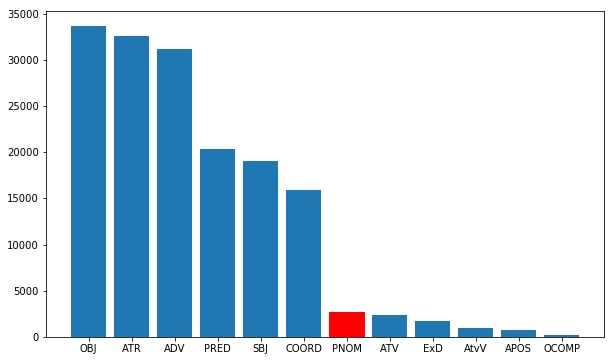

In [142]:
import numpy as np

x = np.arange(len(homrel))
b = plt.bar(x, homrel.values)

# now we color the PNOM-bar red
b[6].set_color('r')
plt.xticks(x, homrel.index)
plt.plot()

#### Frequency of copular vs non-copular use of εἰμί and γίγνομαι

It would be totally possible to get the answer to that question returned directly as the output of a cypher query, but the query would be long, elaborate and possibly quite slow to run. It is much easier (and faster) if we ask for a list of passages with εἰμί or γίγνομαι and optionally test whether this verb has or not a child with the label PNOM. 

We'll do the math later on with `pandas`

In [148]:
res = %cypher {conn} MATCH (h:Token) \
where h.lemma =~ "(εἰμί|γίγνομαι)"  \
OPTIONAL MATCH (h)-[:Dependency*1..2]->(d:Token) \
where d.original_label = "PNOM" \
return h.lemma as Copula, d.original_label as Relation \
    
df = res.get_dataframe()

3569 rows affected.


Now that we have a list of these 3549 observations we use `pandas` to:
* map the `None` to Non-copular and the PNOM to `Copular`
* create a table

In [149]:
df["Construction"] = df['Relation'].apply(lambda x: "Copular" if x == "PNOM" else "Non copular")

In [150]:
pd.crosstab(df.Copula, df.Construction)

Construction,Copular,Non copular
Copula,,
γίγνομαι,216,270
εἰμί,1930,1153


Here we go! We have our numbers.

Do read them with a grain of salt, though. The query is constructed to bypass a couple of situations that might muddy the waters; I can think of two cases:

* the verb governed two or more coordinated PNOMs
* the PNOM is governed by a preposition (some cases of εἰμί|γίγνομαι + prepositions were labelled as such: possibly, it is an error, but they're there)

That's why in line 3 above we ask for: 

```cypher

OPTIONAL MATCH (h)-[:Dependency*1..2]->(d:Token)

```

i.e. a node `h` governing `d` (as PNOM) at a distance of 1 *or 2*; that would allow us to bypass a bridge relation of COORD or AuxP. But it is totally possible that we cast our nets too widely...